In [10]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [12]:
import pulse_compiler_helper_fns

In [5]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [7]:
thetas = np.linspace(0, np.pi/2, 20, endpoint=False)
print(thetas)

[0.         0.07853982 0.15707963 0.23561945 0.31415927 0.39269908
 0.4712389  0.54977871 0.62831853 0.70685835 0.78539816 0.86393798
 0.9424778  1.02101761 1.09955743 1.17809725 1.25663706 1.33517688
 1.41371669 1.49225651]


In [8]:
schedules = []

In [9]:
## Standard Way: Cnot RZ Cnot
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.cx(0, 1)
    circuit.rz(theta, 1)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

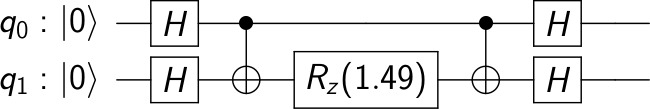

In [9]:
circuit.draw(output='latex')

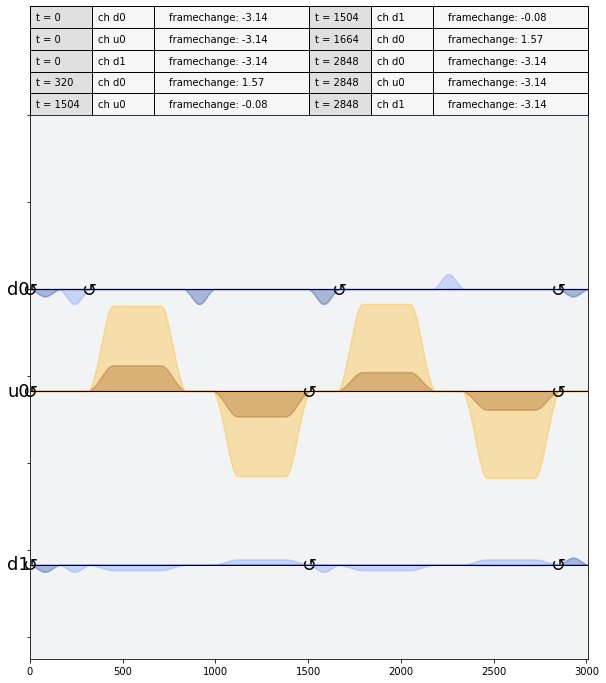

In [23]:
schedules[1].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

In [15]:
## Optimized Way Way: zz_interaction decomposes directly to cross resonancefor theta in thetas:
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.zz_interaction(theta, 0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

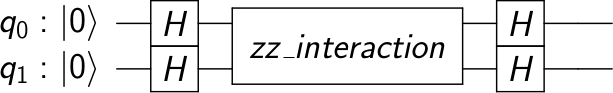

In [16]:
circuit.draw(output='latex')

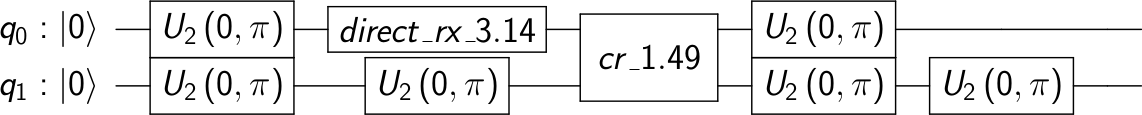

In [17]:
circuit.decompose().draw(output='latex')

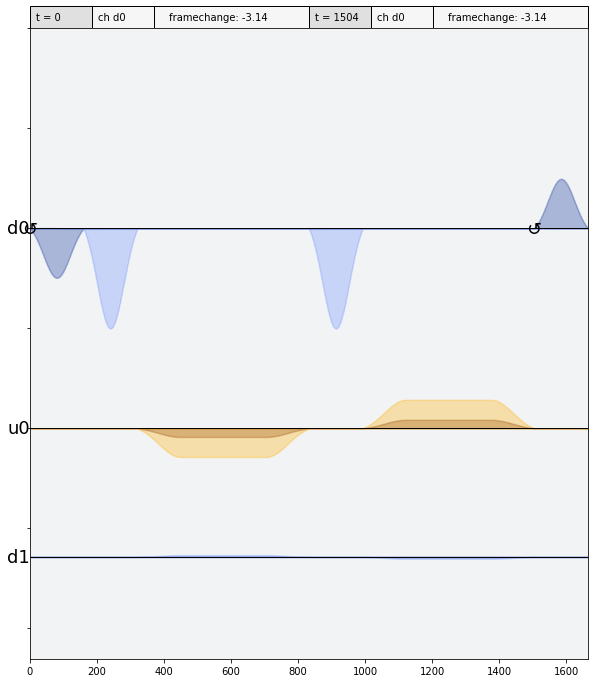

In [22]:
schedules[21].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

In [24]:
shots = 1000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5dd753c92efcfc00184eaf1c


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [33]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

# Run a mitigation cal job

In [60]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, euler_angles_1q
from qiskit.extensions.standard import U3Gate
from qiskit.circuit import Gate

def make_u3s(circ):
    new_circ = QuantumCircuit(*circ.qregs, *circ.cregs)
    for gate, qargs, cargs in circ.data:
        if len(qargs) == 1 and isinstance(gate, Gate):
            theta, phi, lam = euler_angles_1q(Operator(gate).data)
            new_circ.append(U3Gate(theta, phi, lam), qargs, cargs)
        else:
            new_circ.append(gate, qargs, cargs)
    return new_circ

In [22]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
#meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
#meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)
job_mit = q.execute(meas_qcs, backend, initial_layout=[0,1])

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [34]:
job_mit.status()

<JobStatus.DONE: 'job has successfully run'>

-----
## Analysis

In [37]:
result=backend.retrieve_job('5dd753c92efcfc00184eaf1c').result()

In [11]:
result_mit=backend.retrieve_job('5dd75b45c02fc60018634b23').result()

In [21]:
backend.retrieve_job('5dd75b45c02fc60018634b23').qobj().experiments[1].instructions

[QobjInstruction(name='u3', params=[3.141592653589793, 1.5707963267948966, -1.5707963267948966], qubits=[0]),
 QobjInstruction(name='barrier', qubits=[0, 1]),
 QobjInstruction(memory=[0], name='measure', qubits=[0]),
 QobjInstruction(memory=[1], name='measure', qubits=[1])]

In [33]:
readout_fitter.cal_matrix

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [78]:
result = job.result()

In [35]:
# mitigate results
result_mit = job_mit.result()
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)

In [38]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [39]:
standard_counts_list = []
for i in range(len(thetas)):
    counts = marginal_counts(result.get_counts(i), meas_qubits=[0,1])
    counts = readout_fitter.filter.apply(counts)
    standard_counts_list.append(counts)
print(standard_counts_list)

[{'00': 920.721338755942, '01': 9.477757663276678, '10': 65.69405641034913, '11': 4.106847170432124}, {'00': 900.3023505190437, '01': 15.684790848875968, '10': 69.68237130324047, '11': 14.330487328839984}, {'00': 910.1901221642656, '01': 5.78772832694253, '10': 70.78289599907018, '11': 13.239253509721694}, {'00': 907.4304750279287, '01': 7.364864603223704, '10': 62.55041303304296, '11': 22.654247335804687}, {'00': 884.9479815803816, '01': 19.966873716649758, '10': 59.79132110859982, '11': 35.29382359436885}, {'00': 890.7701168005184, '01': 18.433700649873366, '10': 50.6494249949724, '11': 40.14675755463587}, {'00': 857.9515779952942, '01': 19.496245712643944, '10': 57.2080868882047, '11': 65.34408940385707}, {'00': 877.1981376356935, '01': 7.7478483762816115, '10': 42.316297423120155, '11': 72.73771656490472}, {'00': 842.373278598549, '01': 17.512534086542736, '10': 57.46120653912869, '11': 82.65298077577961}, {'00': 790.3870354849254, '01': 16.774033326682748, '10': 53.578633021956264

In [41]:
optimized_counts_list = []
for i in range(len(thetas), len(thetas) * 2):
    counts = marginal_counts(result.get_counts(i), meas_qubits=[0,1])
    counts = readout_fitter.filter.apply(counts)
    optimized_counts_list.append(counts)
print(optimized_counts_list)

[{'00': 952.7932545426188, '01': 4.5476208252846675, '10': 38.999657261471846, '11': 3.6594673706246077}, {'00': 928.4908092219788, '01': 13.659237795853727, '10': 53.478134996480264, '11': 4.371817985687135}, {'00': 912.7919780490745, '01': 21.613568135453747, '10': 46.1209956106345, '11': 19.473458204837186}, {'00': 876.5771784605016, '01': 22.828322183988483, '10': 57.18991957062311, '11': 43.40457978488677}, {'00': 865.4200724333241, '01': 14.237395971097529, '10': 59.62355681842093, '11': 60.7189747771574}, {'00': 845.8244402028856, '01': 18.581605769327016, '10': 69.39040934450036, '11': 66.203544683287}, {'00': 789.473796009634, '01': 17.85251315152427, '10': 68.79092829329726, '11': 123.88276254554432}, {'00': 765.1250688761669, '01': 21.181161356884243, '10': 52.53748528639604, '11': 161.15628448055298}, {'00': 743.588325607762, '01': 14.163265723262061, '10': 52.19151678765551, '11': 190.05689188132044}, {'00': 676.1403264350197, '01': 17.141011627009178, '10': 78.12385970022

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/visualization/counts_visualization.py:187: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


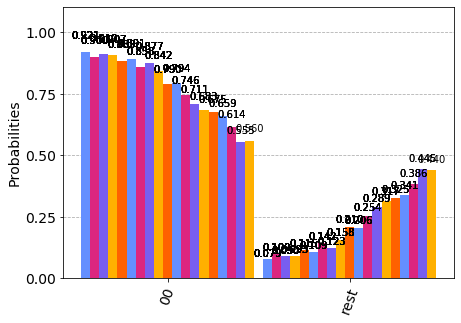

In [42]:
from qiskit.visualization import plot_histogram
plot_histogram(standard_counts_list[:19], number_to_keep=1)

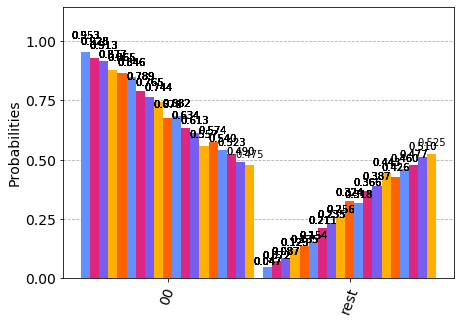

In [43]:
plot_histogram(optimized_counts_list[:19], number_to_keep=1)

In [14]:
# infer output state vectors, up to phase of each element (phase won't matter for overlap calculation)
standard_state_vectors = []
for counts in standard_counts_list:
        standard_state_vectors.append(np.array([
            np.sqrt(counts.get('00', 0)/shots),
            np.sqrt(counts.get('01', 0)/shots),
            np.sqrt(counts.get('10', 0)/shots),
            np.sqrt(counts.get('11', 0)/shots)]))

In [15]:
optimized_state_vectors = []
for counts in optimized_counts_list:
        optimized_state_vectors.append(np.array([
            np.sqrt(counts.get('00', 0)/shots),
            np.sqrt(counts.get('01', 0)/shots),
            np.sqrt(counts.get('10', 0)/shots),
            np.sqrt(counts.get('11', 0)/shots)]))

In [17]:
backend = q.Aer.get_backend('statevector_simulator')
ideal_state_vectors = []
thetas = np.linspace(0, np.pi/2, 20, endpoint=False)
for theta in thetas:
    circuit = q.QuantumCircuit(2, 2)
    circuit.h(0)
    circuit.h(1)
    circuit.cx(0, 1)
    circuit.rz(theta, 1)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.h(1)
    job = q.execute(circuit, backend=backend)
    ideal_state_vectors.append(job.result().get_statevector())

In [21]:
import qutip
standard_overlaps, optimized_overlaps = [], []
for standard, optimized, ideal in zip(standard_state_vectors, optimized_state_vectors, ideal_state_vectors):
    standard_overlaps.append(qutip.fidelity(qutip.Qobj(standard), qutip.Qobj(ideal)))
    optimized_overlaps.append(qutip.fidelity(qutip.Qobj(optimized), qutip.Qobj(ideal)))

Text(0, 0.5, 'Fidelity')

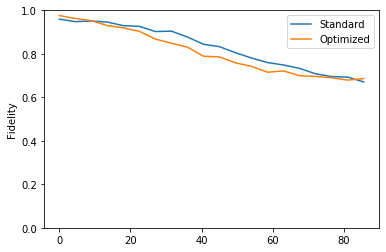

In [25]:
plt.plot(thetas * 180 / np.pi, standard_overlaps, label='Standard')
plt.plot(thetas * 180 / np.pi, optimized_overlaps, label='Optimized')
plt.legend()
plt.ylim(0, 1)
plt.ylabel('Fidelity')

In [27]:
thetas

array([0.        , 0.07853982, 0.15707963, 0.23561945, 0.31415927,
       0.39269908, 0.4712389 , 0.54977871, 0.62831853, 0.70685835,
       0.78539816, 0.86393798, 0.9424778 , 1.02101761, 1.09955743,
       1.17809725, 1.25663706, 1.33517688, 1.41371669, 1.49225651])

In [39]:
# infer output state vectors, up to phase of each element (phase won't matter for overlap calculation)
standard_11s = []
for counts in standard_counts_list:
    standard_11s.append(counts.get('11', 0))
        
optimized_11s = []
for counts in optimized_counts_list:
    optimized_11s.append(counts.get('11', 0))
        
ideal_11s = []
for ideal in ideal_state_vectors:
    ideal_11s.append(1000 * np.abs(ideal[3]) ** 2)

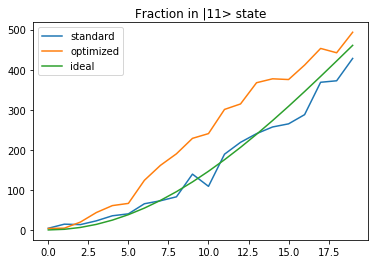

In [41]:
plt.plot(standard_11s, label='standard')
plt.plot(optimized_11s, label='optimized')
plt.plot(ideal_11s, label='ideal')
plt.title('Fraction in |11> state')
plt.legend()

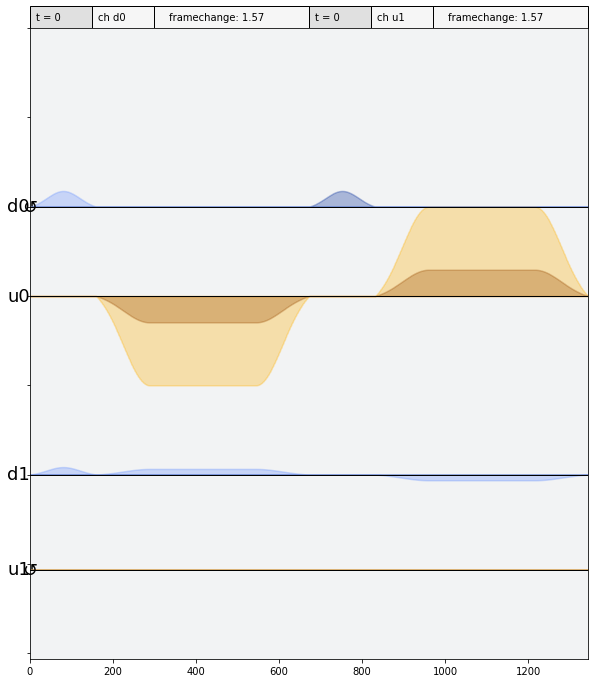

In [44]:
cmd_def.get('cx', qubits=[0, 1]).draw()